## Experiment for Two Interventions

Descrição do caso

In [1]:
# IMPORTS
import os
from gurobipy import Model, GRB
import pandas as pd
import random

os.chdir('/home/lawand/Experiments')

from utils.funcoes import generate_example
from causal_solver.Helper import Helper
from causal_solver.graph import Graph

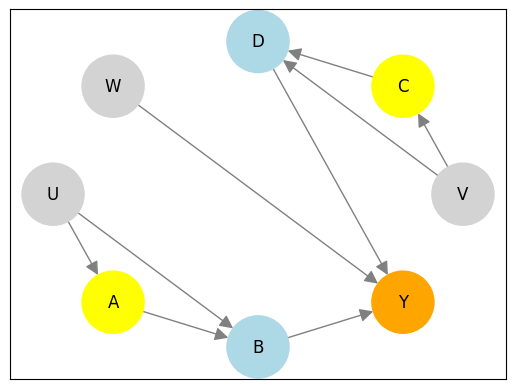

In [3]:
# Imagem que mostra o Grafo
arestas = "U -> A, U -> B, A -> B, B -> Y, V -> C, V -> D, C -> D, D -> Y, W -> Y"
generate_example(arestas, latent=["U", "V", "W"], intervention=["A", "C"], target="Y")

#### Data generation and Setting up the pre-conditions

In [12]:
random.seed(42)
SAMPLES = 1000
# U, V, W: Cardinality 8
def func_U_V_W():
    """Returns a value for U, V, or W (cardinality 8)."""
    PU = [0.05,0.15,0.10,0.20,0.05,0.25,0.10,0.10]
    PV = [0.30,0.10,0.05,0.15,0.05,0.20,0.10,0.05]
    mylist = [i for i in range(len(PU))]
    U_column = random.choices(mylist, weights = PU, k = SAMPLES)
    V_column = random.choices(mylist, weights = PV, k = SAMPLES)
    W_column = random.choices([0,1], weights = [0.5, 0.5], k = SAMPLES)
    return U_column, V_column, W_column

# A: Cardinality 2
def func_A(parent):
    """Returns a value for A or C (cardinality 2) based on a parent."""
    a = []
    for p in parent:
        a.append(1 if p > 4 else 0)
    return a

def func_C(parent):
    """Returns a value for A or C (cardinality 2) based on a parent."""
    c = []
    for p in parent:
        c.append(p % 2)
    return c

# B: Cardinality 2
def func_B(parents):
    """Returns a value for B or D (cardinality 2) based on its parents."""
    b = []
    for i in range(SAMPLES):
            b.append((parents[0][i]+parents[1][i]) % 2)
    return b

# D: Cardinality 2
def func_D(parents):
    lookup_table = {
        (0, 0): 1,
        (0, 1): 0,
        (1, 0): 1,
        (1, 1): 1,
        (2, 0): 1,
        (2, 1): 1,
        (3, 0): 1,
        (3, 1): 0,
        (4, 0): 1,
        (4, 1): 0,
        (5, 0): 0,
        (5, 1): 1,
        (6, 0): 1,
        (6, 1): 0,
        (7, 0): 1,
        (7, 1): 0
    }
    d = []
    for i in range(SAMPLES):
            d.append(lookup_table[(parents[0][i],parents[1][i])])
    return d


# Y: Cardinality 2
def func_Y(parents):
    """Returns a value for Y (cardinality 2) based on its parents."""
    y = []
    for i in range(SAMPLES):
            y.append(1 if ((parents[0][i] == 1 and parents[1][i] == 1) or parents[2][i] == 1) else 0)
    return y

# Example to evaluate the functions
# Assign values to U, V, and W (randomly chosen here)
U, V, W = func_U_V_W()
U_cardinality = 8
V_cardinality = 8

# Compute A and C
A = func_A(U)
C = func_C(V)
A_cardinality = 2
C_cardinality = 2

# Compute B and D
B = func_B([U, A])
D = func_D([V, C])
B_cardinality = 2
D_cardinality = 2
# Compute Y
Y = func_Y([B, D, W])
Y_cardinality = 2

df = pd.DataFrame({
    "A": A,
    "B": B,
    "C": C,
    "D": D,
    "Y": Y,
})


df.to_csv("./Experiments/Example/two_interventions.csv", index=False)

### Generate Mechanisms

In [13]:
test_name = "two_interventions"
dag: Graph = Graph.parse(fromInterface=False,file_path=f"./Experiments/Example/{test_name}.txt")
csvPath = f"./Experiments/Example/{test_name}.csv"
doA = 1
doC = 1
y = 1

print("**************************************************************")
print("Mecanismos de U:")
_,_,u_mechanisms = Helper.mechanisms_generator(latentNode=dag.labelToIndex["U"], endogenousNodes=[dag.labelToIndex["A"],dag.labelToIndex["B"]],
                                        cardinalities=dag.cardinalities,graphNodes=dag.graphNodes,v=False)
print(u_mechanisms)

print("**************************************************************")
print("Mecanismos de V:")
_,_,v_mechanisms = Helper.mechanisms_generator(latentNode=dag.labelToIndex["V"], endogenousNodes=[dag.labelToIndex["C"],dag.labelToIndex["D"]],
                                        cardinalities=dag.cardinalities,graphNodes=dag.graphNodes,v=False)
print(v_mechanisms)

**************************************************************
Mecanismos de U:
[{'': 0, '3=0': 0, '3=1': 0}, {'': 0, '3=0': 0, '3=1': 1}, {'': 0, '3=0': 1, '3=1': 0}, {'': 0, '3=0': 1, '3=1': 1}, {'': 1, '3=0': 0, '3=1': 0}, {'': 1, '3=0': 0, '3=1': 1}, {'': 1, '3=0': 1, '3=1': 0}, {'': 1, '3=0': 1, '3=1': 1}]
**************************************************************
Mecanismos de V:
[{'': 0, '5=0': 0, '5=1': 0}, {'': 0, '5=0': 0, '5=1': 1}, {'': 0, '5=0': 1, '5=1': 0}, {'': 0, '5=0': 1, '5=1': 1}, {'': 1, '5=0': 0, '5=1': 0}, {'': 1, '5=0': 0, '5=1': 1}, {'': 1, '5=0': 1, '5=1': 0}, {'': 1, '5=0': 1, '5=1': 1}]


#### Creating Gurobi's Model

In [14]:
model = Model("Multilinear_Optimization")
number_of_vars = U_cardinality + V_cardinality
vars = model.addVars(number_of_vars, lb=0, ub=1, vtype=GRB.CONTINUOUS, name="vars")

### Função Objetivo e Restrições:

#### Restrições:
$$ P(a,b) = \sum_{u}\underbrace{P(a,b|U)}_{\mathrm{mecanismo}}\underbrace{P(U)}_{\mathrm{variavel}} \\$$
$$ P(c,d) = \sum_{v}\underbrace{P(c,d|V)}_{\mathrm{mecanismo}}\underbrace{P(V)}_{\mathrm{variavel}}$$

In [15]:
# Restrições em U
abRlt = {}
i = 0
for aVal in range(2):
    for bVal in range(2):
        abRlt[dag.labelToIndex["A"]] = aVal
        abRlt[dag.labelToIndex["B"]] = bVal

        expression = 0
        for u in range(len(u_mechanisms)):
            if (u_mechanisms[u][str(dag.labelToIndex["A"])+"="+str(aVal)] == bVal) and (u_mechanisms[u][""] == aVal):
                expression += vars[u]
        empirical = Helper.findProbability(dataFrame=df, indexToLabel= dag.indexToLabel, variableRealizations=abRlt)
        model.addConstr(expression == empirical, name=f"constraint_u_{i}")
        i+=1

expression = 0
for u in range(U_cardinality):
    expression += vars[u]
model.addConstr(expression == 1.0, name=f"constraint_Total_U")


# Restrições em V
cdRlt = {}
i = 0
for cVal in range(2):
    for dVal in range(2):
        cdRlt[dag.labelToIndex["C"]] = cVal
        cdRlt[dag.labelToIndex["D"]] = dVal

        expression = 0
        for v in range(len(v_mechanisms)):
            if (v_mechanisms[v][str(dag.labelToIndex["C"])+"="+str(cVal)] == dVal) and (v_mechanisms[v][""] == cVal):
                expression += vars[v+8]
        empirical = Helper.findProbability(dataFrame=df, indexToLabel= dag.indexToLabel, variableRealizations=cdRlt)
        model.addConstr(expression == empirical, name=f"constraint_v_{i}")
        i+=1

expression = 0
for v in range(V_cardinality):
    expression += vars[v+8]
model.addConstr(expression == 1.0, name=f"constraint_Total_V")

Count compatible cases: 210
Total cases: 1000
Count compatible cases: 322
Total cases: 1000
Count compatible cases: 364
Total cases: 1000
Count compatible cases: 104
Total cases: 1000
Count compatible cases: 0
Total cases: 1000
Count compatible cases: 472
Total cases: 1000
Count compatible cases: 200
Total cases: 1000
Count compatible cases: 328
Total cases: 1000


<gurobi.Constr *Awaiting Model Update*>

#### Função Objetivo:
$$ P(y|do(a),do(c)) = \sum_{b,d}P(y|B,D,do(c),do(a))P(B|do(a))P(D|do(c)) \\
= \sum_{b,d,u,v}\underbrace{P(y|B,D)}_{\mathrm{dados}}\underbrace{P(B|a,U)P(D|c,V)}_{\mathrm{mecanismos}}\underbrace{P(U)P(V)}_{\mathrm{variaveis \ de \ otimizacao(bilinear)}}$$

In [16]:
bdRlt ={}
yRlt = {}
yRlt[dag.labelToIndex["Y"]] = y
expression = 0
for v in range(len(v_mechanisms)):
    for u in range(len(u_mechanisms)):
        for b in range(2):
            coef = 0
            bdRlt[dag.labelToIndex["B"]] = b
            for d in range(2):
                bdRlt[dag.labelToIndex["D"]] = d
                if u_mechanisms[u][str(dag.labelToIndex["A"])+"="+str(doA)] == b and v_mechanisms[v][str(dag.labelToIndex["C"])+"="+str(doC)] == d:
                    coef += Helper.findConditionalProbability(dataFrame=df, indexToLabel= dag.indexToLabel, targetRealization=yRlt, conditionRealization= bdRlt)
            expression += (coef*vars[u]*vars[v+8])  

model.setObjective(expression, GRB.MAXIMIZE)

#### Optimize

In [17]:
# Solve the model
model.optimize()

# Print the results
if model.status == GRB.OPTIMAL:
    print(f"Optimal solution found:")
    print(f"Objective value = {model.ObjVal}")
else:
    print(f"Model status: {model.status}.")
    print("No optimal solution found.")

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 10 rows, 16 columns and 32 nonzeros
Model fingerprint: 0xe14fbd37
Model has 64 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+00]
Presolve removed 3 rows and 2 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 3 rows and 2 columns
Presolve time: 0.00s
Presolved: 104 rows, 64 columns, 255 nonzeros
Presolved model has 48 bilinear constraint(s)
Variable types: 64 continuous, 0 integer (0 binary)
Found heuristic solution: objective 0.7510444

Root relaxation: objective 1.206486e+00, 60 iterations, 0.00 seconds (0.00 work units)

    Node

### Code in Script

In [18]:
# Imagem que mostra o Grafo
import os
os.chdir('/home/lawand/Experiments')
from utils.funcoes import generate_example

from gurobipy import Model, GRB
from causal_solver.Helper import Helper
from causal_solver.graph import Graph
import pandas as pd

def main():
    test_name = "two_interventions"
    dag: Graph = Graph.parse(fromInterface=False,file_path=f"./Experiments/Example/{test_name}.txt")
    csvPath = f"./Experiments/Example/{test_name}.csv"

    doA = 1
    doC = 1
    y = 1

    U_cardinality = 8
    V_cardinality = 8
    df = pd.read_csv(csvPath)

    model = Model("Multilinear_Optimization")
    number_of_vars = U_cardinality + V_cardinality
    vars = model.addVars(number_of_vars, lb=0, ub=1, vtype=GRB.CONTINUOUS, name="vars")

    # Restrições em U
    _,_,u_mechanisms = Helper.mechanisms_generator(latentNode=dag.labelToIndex["U"], endogenousNodes=[dag.labelToIndex["A"],dag.labelToIndex["B"]],
                                            cardinalities=dag.cardinalities,graphNodes=dag.graphNodes,v=False)
    abRlt = {}
    i = 0
    for aVal in range(2):
        for bVal in range(2):
            abRlt[dag.labelToIndex["A"]] = aVal
            abRlt[dag.labelToIndex["B"]] = bVal

            expression = 0
            for u in range(len(u_mechanisms)):
                if (u_mechanisms[u][str(dag.labelToIndex["A"])+"="+str(aVal)] == bVal) and (u_mechanisms[u][""] == aVal):
                    expression += vars[u]
            empirical = Helper.findProbability(dataFrame=df, indexToLabel= dag.indexToLabel, variableRealizations=abRlt)
            model.addConstr(expression == empirical, name=f"constraint_u_{i}")
            i+=1

    expression = 0
    for u in range(U_cardinality):
        expression += vars[u]
    model.addConstr(expression == 1.0, name=f"constraint_Total_U")


    # Restrições em V
    _,_,v_mechanisms = Helper.mechanisms_generator(latentNode=dag.labelToIndex["V"], endogenousNodes=[dag.labelToIndex["C"],dag.labelToIndex["D"]],
                                            cardinalities=dag.cardinalities,graphNodes=dag.graphNodes,v=False)
    cdRlt = {}
    i = 0
    for cVal in range(2):
        for dVal in range(2):
            cdRlt[dag.labelToIndex["C"]] = cVal
            cdRlt[dag.labelToIndex["D"]] = dVal

            expression = 0
            for v in range(len(v_mechanisms)):
                if (v_mechanisms[v][str(dag.labelToIndex["C"])+"="+str(cVal)] == dVal) and (v_mechanisms[v][""] == cVal):
                    expression += vars[v+8]
            empirical = Helper.findProbability(dataFrame=df, indexToLabel= dag.indexToLabel, variableRealizations=cdRlt)
            model.addConstr(expression == empirical, name=f"constraint_v_{i}")
            i+=1

    expression = 0
    for v in range(V_cardinality):
        expression += vars[v+8]
    model.addConstr(expression == 1.0, name=f"constraint_Total_V")

    bdRlt ={}
    yRlt = {}
    yRlt[dag.labelToIndex["Y"]] = y
    expression = 0
    for v in range(len(v_mechanisms)):
        for u in range(len(u_mechanisms)):
            for b in range(2):
                coef = 0
                bdRlt[dag.labelToIndex["B"]] = b
                for d in range(2):
                    bdRlt[dag.labelToIndex["D"]] = d
                    if u_mechanisms[u][str(dag.labelToIndex["A"])+"="+str(doA)] == b and v_mechanisms[v][str(dag.labelToIndex["C"])+"="+str(doC)] == d:
                        coef += Helper.findConditionalProbability(dataFrame=df, indexToLabel= dag.indexToLabel, targetRealization=yRlt, conditionRealization= bdRlt)
                expression += (coef*vars[u]*vars[v+8])  

    model.setObjective(expression, GRB.MAXIMIZE)

    # Solve the model
    model.optimize()

    # Print the results
    if model.status == GRB.OPTIMAL:
        print(f"Optimal solution found:")
        print(f"Objective value = {model.ObjVal}")
    else:
        print(f"Model status: {model.status}.")
        print("No optimal solution found.")

main()

Count compatible cases: 210
Total cases: 1000
Count compatible cases: 322
Total cases: 1000
Count compatible cases: 364
Total cases: 1000
Count compatible cases: 104
Total cases: 1000
Count compatible cases: 0
Total cases: 1000
Count compatible cases: 472
Total cases: 1000
Count compatible cases: 200
Total cases: 1000
Count compatible cases: 328
Total cases: 1000
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 10 rows, 16 columns and 32 nonzeros
Model fingerprint: 0xe14fbd37
Model has 64 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+00]
Presolve removed 3 rows and 2 columns

Continuous model is non-convex -